<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/Semantic_Segmentation_Composer_Data_2_Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install torchmetrics
!pip install scikit-plot
!pip install mosaicml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from transformers import AutoFeatureExtractor, Data2VecVisionForSemanticSegmentation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

import scikitplot as skplt
from torchmetrics import Accuracy, MatthewsCorrCoef, MetricCollection, JaccardIndex
from tqdm import tqdm
import composer
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_data = datasets.OxfordIIITPet(
    root='.', download=True, target_types='segmentation'
)

test_data = datasets.OxfordIIITPet(
    root='.', download=True, target_types='segmentation', split='test'
)

# EDA

In [4]:
img, seg = next(iter(train_data))

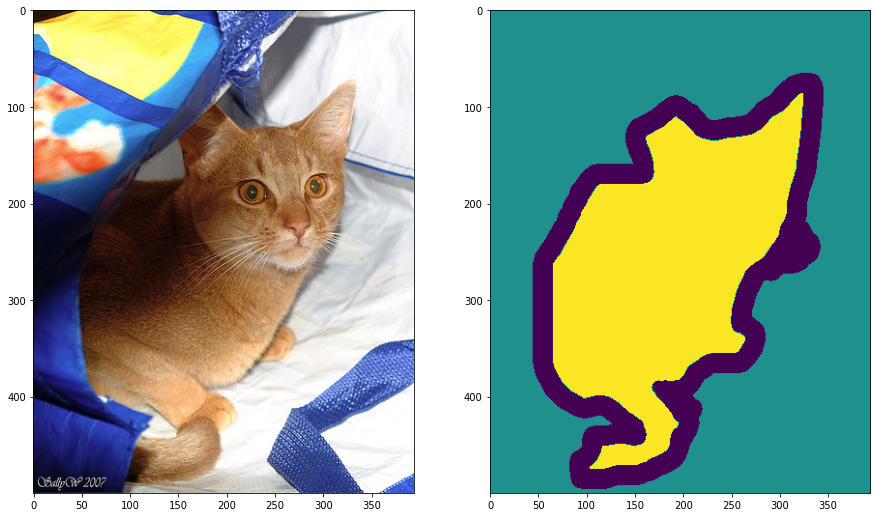

In [5]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(np.array(seg) * 255)

# Build Dataloader

In [6]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/data2vec-vision-base")
model = Data2VecVisionForSemanticSegmentation.from_pretrained("facebook/data2vec-vision-base", num_labels=len(train_data.classes))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of Data2VecVisionForSemanticSegmentation were not initialized from the model checkpoint at facebook/data2vec-vision-base and are newly initialized: ['decode_head.lateral_convs.2.bn.running_mean', 'decode_head.bottleneck.bn.weight', 'decode_head.fpn_convs.2.bn.num_batches_tracked', 'decode_head.fpn_convs.1.bn.running_var', 'decode_head.lateral_convs.1.bn.weight', 'decode_head.psp_modules.0.1.bn.bias', 'decode_head.psp_modules.0.1.bn.weight', 'decode_head.fpn_convs.1.bn.running_mean', 'fpn1.3.bias', 'decode_head.bottleneck.bn.running_mean', 'decode_head.fpn_convs.1.bn.weight', 'decode_head.fpn_bottleneck.conv.weight', 'decode_head.psp_modules.1.1.bn.bias', 'decode_head

In [7]:
class OxfordDataset(Dataset):
  def __init__(self, data, feature_extractor):
    self.data = data
    self.feature_extractor = feature_extractor

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image, annot = self.data[index]

    encoded_inputs = self.feature_extractor(
        image, annot, return_tensors='pt'
    )

    return {
        'pixel_values': encoded_inputs['pixel_values'].squeeze(0),
        'labels': encoded_inputs['labels'].squeeze(0)
    }

In [8]:
train_dataset = OxfordDataset(train_data, feature_extractor)
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)


test_dataset = OxfordDataset(test_data, feature_extractor)
test_dataloader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True
)

In [9]:
train_datasspec = composer.DataSpec(test_dataloader)
test_dataspec = composer.DataSpec(test_dataloader)

# Build model

In [10]:
class OxfordSegModel(composer.ComposerModel):
  def __init__(self, model):
        super(OxfordSegModel, self).__init__()

        self.model = model

        # Metrics
        self.train_iou = JaccardIndex(len(train_data.classes))
        self.val_iou = JaccardIndex(len(train_data.classes))
   
  def forward(self, batch):
      return self.model(**batch)

  def loss(self, outputs, batch):
      return outputs.loss

  def validate(self, batch):
      labels = batch['labels']
      output = self.forward(batch)

      upsampled_logits = F.interpolate(output.logits, size=labels.shape[-2:], mode='bilinear', align_corners=False)
      seg = upsampled_logits.argmax(dim=1)

      return (seg, labels)
  
  def metrics(self, train: bool = False):
      return MetricCollection([
          self.train_iou
      ]) if train else MetricCollection([self.val_iou])

In [11]:
oxford_segmodel = OxfordSegModel(model)

# Train model

In [12]:
epochs = 5
optimizer = torch.optim.AdamW(oxford_segmodel.parameters(), lr=5e-5)

In [13]:
trainer = composer.Trainer(
    model=oxford_segmodel, 
    train_dataloader=train_datasspec,
    eval_dataloader=test_dataspec,
    max_duration=str(epochs) + "ep",
    optimizers=optimizer,
    device='gpu',
    precision='fp32',
    seed=42,
    save_filename="ep{epoch}-ba{batch}-rank{rank}.pt",
    save_folder="./checkpoints",
    save_overwrite=True,
    save_interval="1ep",
)

In [14]:
trainer.fit()

Epoch     0 train   0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     1 val     0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     1 train   0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     2 val     0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     2 train   0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     3 val     0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     3 train   0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     4 val     0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     4 train   0%|                         | 0/58 [00:00<?, ?it/s]         

Epoch     5 val     0%|                         | 0/58 [00:00<?, ?it/s]         

In [15]:
!nvidia-smi

Wed Jun  8 11:51:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |  12344MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Evaluate Model

In [16]:
preds = []
gts = []
iou = JaccardIndex(len(train_data.classes)).cuda()

model.eval();
model.cuda();

for item in tqdm(test_dataspec.dataloader):
  item['pixel_values'] = item['pixel_values'].cuda()
  item['labels'] = item['labels'].cuda()
  
  with torch.no_grad():
    outputs = model(**item)

  upsampled_logits = F.interpolate(outputs.logits, size=item['pixel_values'].shape[-2:], mode='bilinear', align_corners=False)
  seg = upsampled_logits.argmax(dim=1)
  iou.update(seg, item['labels'])

'IoU: {}'.format(iou.compute().detach().cpu().item())

100%|██████████| 58/58 [18:49<00:00, 19.47s/it]


'IoU: 0.06770186126232147'

# Inference

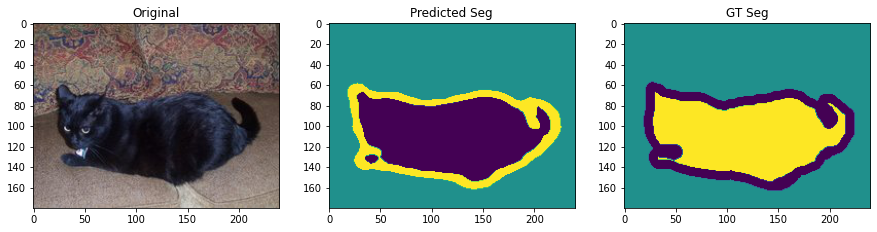

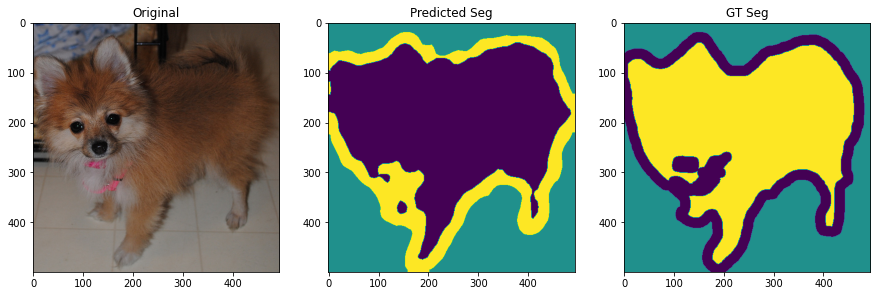

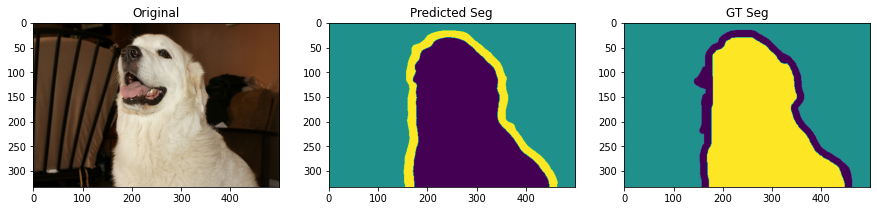

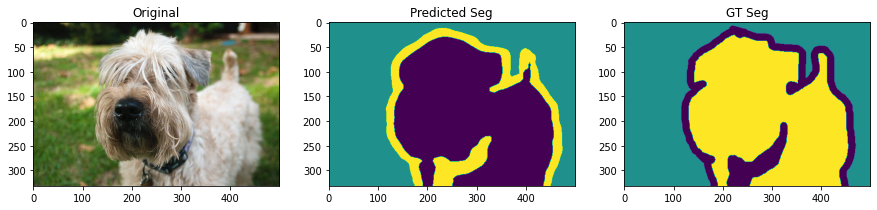

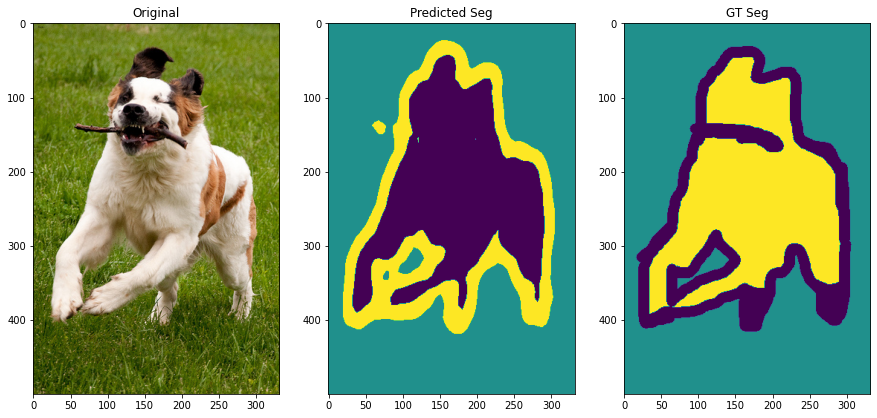

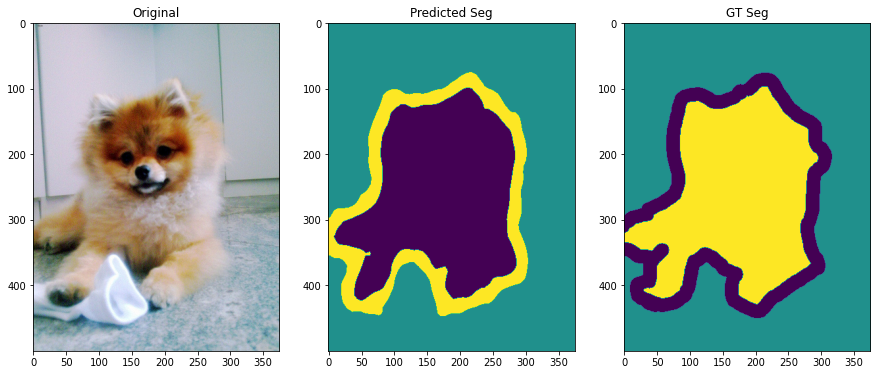

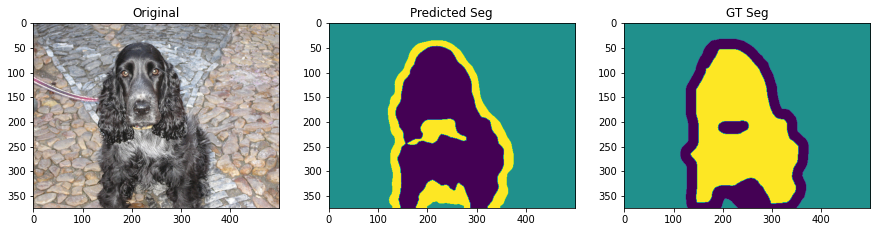

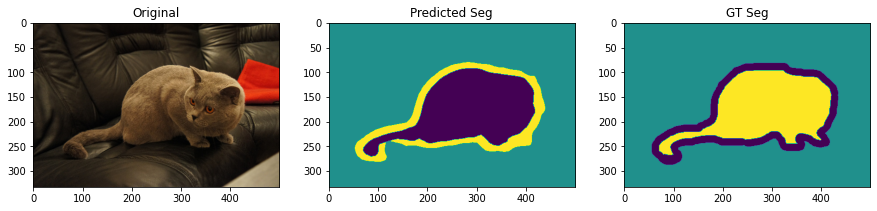

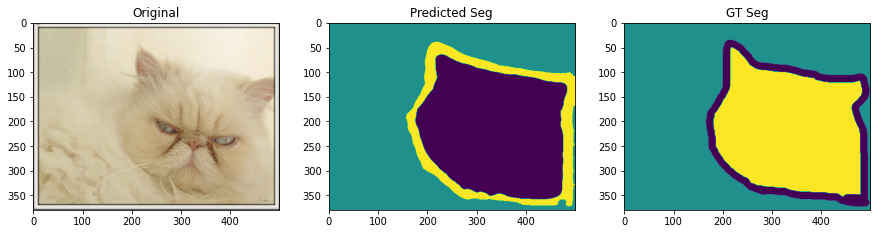

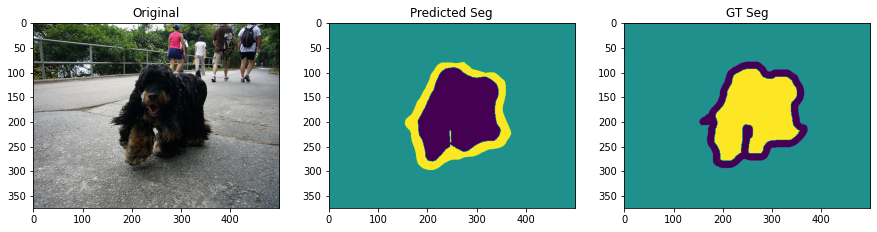

In [33]:
random_vars = np.random.randint(0, len(test_data) -1, (10))
for i in random_vars:
  selected = test_data[i]
  extracted = feature_extractor(selected[0], return_tensors='pt')
  extracted['pixel_values'] = extracted['pixel_values'].cuda()
  pred = model(**extracted)
  # First, rescale logits to original image size
  upsampled_logits = F.interpolate(pred.logits, size=selected[0].size[::-1], mode='bilinear', align_corners=False)
  seg = upsampled_logits.argmax(dim=1)[0]
  seg = seg.detach().cpu().numpy()
  plt.figure(figsize=(15, 10))
  plt.subplot(1, 3, 1)
  plt.title('Original')
  plt.imshow(selected[0])

  plt.subplot(1, 3, 2)
  plt.title('Predicted Seg')
  plt.imshow(seg * 255)

  plt.subplot(1, 3, 3)
  plt.title('GT Seg')
  plt.imshow(np.array(selected[1]) * 255)